# Descripci√≥n

La compa√±√≠a de seguros Sure Tomorrow quiere resolver varias tareas con la ayuda de machine learning y te pide que eval√∫es esa posibilidad.

- Tarea 1: encontrar clientes que sean similares a un cliente determinado. Esto ayudar√° a los agentes de la compa√±√≠a con el marketing.
- Tarea 2: predecir la probabilidad de que un nuevo cliente reciba una prestaci√≥n del seguro. ¬øPuede un modelo de predictivo funcionar mejor que un modelo dummy?
- Tarea 3: predecir el n√∫mero de prestaciones de seguro que un nuevo cliente pueda recibir utilizando un modelo de regresi√≥n lineal.
- Tarea 4: proteger los datos personales de los clientes sin afectar al modelo del ejercicio anterior. Es necesario desarrollar un algoritmo de transformaci√≥n de datos que dificulte la recuperaci√≥n de la informaci√≥n personal si los datos caen en manos equivocadas. Esto se denomina enmascaramiento u ofuscaci√≥n de datos. Pero los datos deben protegerse de tal manera que no se vea afectada la calidad de los modelos de machine learning. No es necesario elegir el mejor modelo, basta con demostrar que el algoritmo funciona correctamente.


# Preprocesamiento y exploraci√≥n de datos

## Inicializaci√≥n

In [64]:
import numpy as np
import pandas as pd

import seaborn as sns
import math

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing

from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

from sklearn.linear_model import LinearRegression

from IPython.display import display


## Carga de datos

Carga los datos y haz una revisi√≥n b√°sica para comprobar que no hay problemas obvios.

In [3]:
df = pd.read_csv('insurance_us.csv')

Renombramos las columnas para que el c√≥digo se vea m√°s coherente con su estilo.

In [4]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [5]:
df.sample(10)

gender   age   income  family_members  insurance_benefits
4565       0  26.0  28000.0               1                   0
1987       1  32.0  31800.0               0                   0
2555       1  21.0  42200.0               0                   0
1462       0  33.0  48000.0               0                   0
1777       0  18.0  42200.0               1                   0
2917       0  29.0  43200.0               1                   0
2649       1  29.0  38800.0               5                   0
349        1  28.0  25500.0               0                   0
3350       1  22.0  38800.0               4                   0
77         1  40.0  37600.0               2                   0

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [7]:
# puede que queramos cambiar el tipo de edad (de float a int) aunque esto no es crucial

# escribe tu conversi√≥n aqu√≠ si lo deseas:
df['age'] = df['age'].astype('int')

In [8]:
# comprueba que la conversi√≥n se haya realizado con √©xito
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


In [9]:
# ahora echa un vistazo a las estad√≠sticas descriptivas de los datos.
# ¬øSe ve todo bien?

In [10]:
df.describe()

gender          age        income  family_members  \
count  5000.000000  5000.000000   5000.000000     5000.000000   
mean      0.499000    30.952800  39916.360000        1.194200   
std       0.500049     8.440807   9900.083569        1.091387   
min       0.000000    18.000000   5300.000000        0.000000   
25%       0.000000    24.000000  33300.000000        0.000000   
50%       0.000000    30.000000  40200.000000        1.000000   
75%       1.000000    37.000000  46600.000000        2.000000   
max       1.000000    65.000000  79000.000000        6.000000   

       insurance_benefits  
count         5000.000000  
mean             0.148000  
std              0.463183  
min              0.000000  
25%              0.000000  
50%              0.000000  
75%              0.000000  
max              5.000000

Todos los datos se ven normales a excepci√≥n de la variable insurance_benefits, que est√° fuertemente sesgada ya que s√≥lo unos pocos registros tienen beneficios mayores que cero.

## An√°lisis exploratorio de datos

Vamos a comprobar r√°pidamente si existen determinados grupos de clientes observando el gr√°fico de pares.

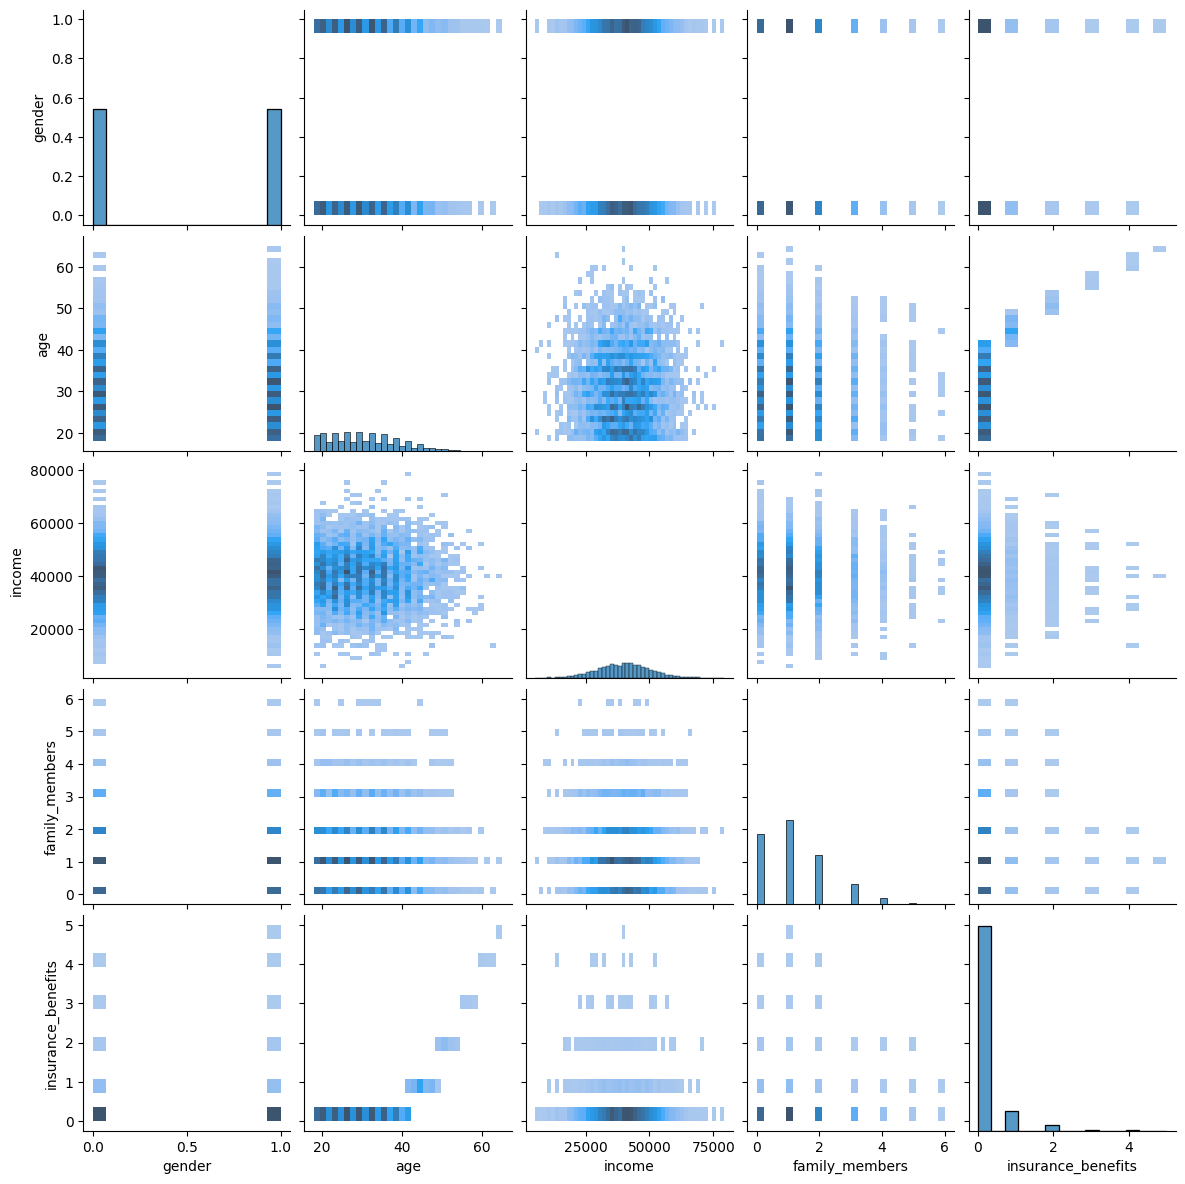

In [11]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

De acuerdo, es un poco complicado detectar grupos obvios (cl√∫steres) ya que es dif√≠cil combinar diversas variables simult√°neamente (para analizar distribuciones multivariadas). Ah√≠ es donde LA y ML pueden ser bastante √∫tiles.

# Tarea 1. Clientes similares

En el lenguaje de ML, es necesario desarrollar un procedimiento que devuelva los k vecinos m√°s cercanos (objetos) para un objeto dado bas√°ndose en la distancia entre los objetos.

Es posible que quieras revisar las siguientes lecciones (cap√≠tulo -> lecci√≥n)
- Distancia entre vectores -> Distancia euclidiana
- Distancia entre vectores -> Distancia Manhattan

Para resolver la tarea, podemos probar diferentes m√©tricas de distancia.

Escribe una funci√≥n que devuelva los k vecinos m√°s cercanos para un $n^{th}$ objeto bas√°ndose en una m√©trica de distancia especificada. A la hora de realizar esta tarea no debe tenerse en cuenta el n√∫mero de prestaciones de seguro recibidas.

Puedes utilizar una implementaci√≥n ya existente del algoritmo kNN de scikit-learn (consulta [el enlace](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) o tu propia implementaci√≥n.

Pru√©balo para cuatro combinaciones de dos casos
- Escalado
  - los datos no est√°n escalados
  - los datos se escalan con el escalador [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html)
- M√©tricas de distancia
  - Euclidiana
  - Manhattan

Responde a estas preguntas:
- ¬øEl hecho de que los datos no est√©n escalados afecta al algoritmo kNN? Si es as√≠, ¬øc√≥mo se manifiesta?
- ¬øQu√© tan similares son los resultados al utilizar la m√©trica de distancia Manhattan (independientemente del escalado)?

In [12]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [13]:
def get_knn(df, n, k, metric):
    
    """
    Devuelve los k vecinos m√°s cercanos

    :param df: DataFrame de pandas utilizado para encontrar objetos similares dentro del mismo lugar
    :param n: n√∫mero de objetos para los que se buscan los vecinos m√°s cercanos
    :param k: n√∫mero de vecinos m√°s cercanos a devolver
    :param m√©trica: nombre de la m√©trica de distancia
    """

    nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=k, metric=metric)
    nbrs.fit(df[feature_names])
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

Escalar datos.

In [14]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

C:\Users\estilos\AppData\Local\Temp\ipykernel_10652\760832288.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.63076923 0.70769231 0.44615385 ... 0.30769231 0.33846154 0.43076923]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())
C:\Users\estilos\AppData\Local\Temp\ipykernel_10652\760832288.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.16666667 0.16666667 0.         ... 0.33333333 0.5        0.16666667]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())


In [15]:
df_scaled.sample(5)

gender       age    income  family_members  insurance_benefits
359        0  0.461538  0.492405        0.000000                   0
4628       1  0.630769  0.411392        0.666667                   0
2984       1  0.507692  0.354430        0.166667                   0
1684       1  0.692308  0.743038        0.166667                   1
1533       0  0.276923  0.350633        0.000000                   0

Ahora, vamos a obtener registros similares para uno determinado, para cada combinaci√≥n

In [16]:
###Sin escalar con distancia euclideana
sin_escalar_euclidean = get_knn(df[feature_names],n=0,k=10,metric='euclidean')
sin_escalar_euclidean

c:\Users\estilos\Data Science\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


gender  age   income  family_members  distance
0          1   41  49600.0               1  0.000000
2022       1   41  49600.0               0  1.000000
1225       0   42  49600.0               0  1.732051
4031       1   44  49600.0               2  3.162278
3424       0   38  49600.0               0  3.316625
815        1   37  49600.0               2  4.123106
4661       0   45  49600.0               0  4.242641
2125       0   37  49600.0               2  4.242641
3900       1   36  49600.0               0  5.099020
2349       1   46  49600.0               2  5.099020

In [17]:
###Sin escalar con distancia Manhattan
sin_escalar_Manhattan= get_knn(df[feature_names],n=0,k=10,metric='manhattan')
sin_escalar_Manhattan

c:\Users\estilos\Data Science\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


gender  age   income  family_members  distance
0          1   41  49600.0               1       0.0
2022       1   41  49600.0               0       1.0
1225       0   42  49600.0               0       3.0
4031       1   44  49600.0               2       4.0
3424       0   38  49600.0               0       5.0
815        1   37  49600.0               2       5.0
4661       0   45  49600.0               0       6.0
2349       1   46  49600.0               2       6.0
2125       0   37  49600.0               2       6.0
3900       1   36  49600.0               0       6.0

In [18]:
###Escalado con distancia Euclideana
escalado_euclidean = get_knn(df_scaled[feature_names],n=0,k=10,metric='euclidean')
escalado_euclidean

c:\Users\estilos\Data Science\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


gender       age    income  family_members  distance
0          1  0.630769  0.627848        0.166667  0.000000
2689       1  0.630769  0.634177        0.166667  0.006329
133        1  0.615385  0.636709        0.166667  0.017754
4869       1  0.646154  0.637975        0.166667  0.018418
3275       1  0.646154  0.651899        0.166667  0.028550
1567       1  0.615385  0.602532        0.166667  0.029624
3365       1  0.630769  0.596203        0.166667  0.031646
2103       1  0.630769  0.596203        0.166667  0.031646
124        1  0.661538  0.635443        0.166667  0.031693
3636       1  0.615385  0.600000        0.166667  0.031815

In [19]:
###Escalado con distancia Manhattan
escalado_Manhattan = get_knn(df_scaled[feature_names],n=0,k=10,metric='manhattan')
escalado_Manhattan

c:\Users\estilos\Data Science\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


gender       age    income  family_members  distance
0          1  0.630769  0.627848        0.166667  0.000000
2689       1  0.630769  0.634177        0.166667  0.006329
133        1  0.615385  0.636709        0.166667  0.024245
4869       1  0.646154  0.637975        0.166667  0.025511
3365       1  0.630769  0.596203        0.166667  0.031646
2103       1  0.630769  0.596203        0.166667  0.031646
124        1  0.661538  0.635443        0.166667  0.038364
4305       1  0.630769  0.588608        0.166667  0.039241
3275       1  0.646154  0.651899        0.166667  0.039435
1567       1  0.615385  0.602532        0.166667  0.040701

Respuestas a las preguntas

**¬øEl hecho de que los datos no est√©n escalados afecta al algoritmo kNN? Si es as√≠, ¬øc√≥mo se manifiesta?**

Los datos notorios son los ingresos, que a buscar los knn vecinos m√°s cercanos, todos los ingresos tienen el mismo monto

**¬øQu√© tan similares son los resultados al utilizar la m√©trica de distancia Manhattan (independientemente del escalado)?** 

Utilizando la distancia Manhattan, vemos que varios datos son muy similares, por no decir que son iguales, en datos como el ingreso y el n√∫mero de miembros de la familia, vemos datos iguales en todos los knn vecinos m√°s cercanos.

# Tarea 2. ¬øEs probable que el cliente reciba una prestaci√≥n del seguro?

En t√©rminos de machine learning podemos considerarlo como una tarea de clasificaci√≥n binaria.

Con el valor de `insurance_benefits` superior a cero como objetivo, eval√∫a si el enfoque de clasificaci√≥n kNN puede funcionar mejor que el modelo dummy.

Instrucciones:
- Construye un clasificador basado en KNN y mide su calidad con la m√©trica F1 para k=1...10 tanto para los datos originales como para los escalados. Ser√≠a interesante observar c√≥mo k puede influir en la m√©trica de evaluaci√≥n y si el escalado de los datos provoca alguna diferencia. Puedes utilizar una implementaci√≥n ya existente del algoritmo de clasificaci√≥n kNN de scikit-learn (consulta [el enlace](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) o tu propia implementaci√≥n.
- Construye un modelo dummy que, en este caso, es simplemente un modelo aleatorio. Deber√≠a devolver "1" con cierta probabilidad. Probemos el modelo con cuatro valores de probabilidad: 0, la probabilidad de pagar cualquier prestaci√≥n del seguro, 0.5, 1.

La probabilidad de pagar cualquier prestaci√≥n del seguro puede definirse como

$$
P\{\text{prestaci√≥n de seguro recibida}\}=\frac{\text{n√∫mero de clientes que han recibido alguna prestaci√≥n de seguro}}{\text{n√∫mero total de clientes}}.
$$

Divide todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporci√≥n 70:30.

In [20]:
### —Åalcula el objetivo

df['insurance_benefits_received'] =  (df['insurance_benefits']>0).astype(int)
p_insurance_received = (df['insurance_benefits_received'].sum())/len(df)
print(f'La probabilidad de pagar cualquier prestaci√≥n de seguro es de {p_insurance_received*100}%.')

La probabilidad de pagar cualquier prestaci√≥n de seguro es de 11.28%.


In [21]:
# comprueba el desequilibrio de clases con value_counts()

conteo_de_clases=df['insurance_benefits_received'].value_counts()
conteo_de_clases


insurance_benefits_received
0    4436
1     564
Name: count, dtype: int64

In [22]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# si tienes alg√∫n problema con la siguiente l√≠nea, reinicia el kernel y ejecuta el cuaderno de nuevo
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Matriz de confusi√≥n')
    print(cm)

In [23]:
# generar la salida de un modelo aleatorio

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [24]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'La probabilidad: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, size=len(df),seed=42)
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

La probabilidad: 0.00
F1: 0.00
Matriz de confusi√≥n
[[0.8872 0.    ]
 [0.1128 0.    ]]

La probabilidad: 0.11
F1: 0.12
Matriz de confusi√≥n
[[0.7914 0.0958]
 [0.0994 0.0134]]

La probabilidad: 0.50
F1: 0.20
Matriz de confusi√≥n
[[0.456  0.4312]
 [0.053  0.0598]]

La probabilidad: 1.00
F1: 0.20
Matriz de confusi√≥n
[[0.     0.8872]
 [0.     0.1128]]



#KNN vecinos

In [25]:
### Definir variables de entrada y objetivo sin escalar
X= df[feature_names]
y= df['insurance_benefits_received']

# Dividir en train/test (70:30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= 42)

f1_scores = []


for k in range(1, 11):
    # modelo sin escalar
    knn = KNeighborsClassifier(n_neighbors=k)
    # Entrenar el modelo con los datos originales
    knn.fit(X_train,y_train)
    y_pred_orig = knn.predict(X_test)
    f1_orig = f1_score(y_test, y_pred_orig)
    f1_scores.append(f1_orig)

print("F1 scores para datos originales:", f1_scores)


F1 scores para datos originales: [0.6523297491039427, 0.37623762376237624, 0.3853211009174312, 0.15555555555555556, 0.16842105263157894, 0.09411764705882353, 0.11560693641618497, 0.024539877300613498, 0.036585365853658534, 0.036585365853658534]


In [26]:
### —Åalcula el objetivo escalado

df_scaled['insurance_benefits_received'] =  (df_scaled['insurance_benefits']>0).astype(int)
p_insurance_received_esc = (df_scaled['insurance_benefits_received'].sum())/len(df)
print(f'La probabilidad de pagar cualquier prestaci√≥n de seguro es de {p_insurance_received_esc*100}%.')

La probabilidad de pagar cualquier prestaci√≥n de seguro es de 11.28%.


In [27]:
### Definir variables de entrada y objetivo escalados
X_esc= df_scaled[feature_names]
y_esc= df_scaled['insurance_benefits_received']

# Dividir en train/test (70:30)
X_esc_train, X_esc_test, y_esc_train, y_esc_test = train_test_split(X_esc, y_esc, test_size=0.3, random_state= 42)

f1_scores_scaled = []


for k in range(1, 11):
    knn_scaled = KNeighborsClassifier(n_neighbors=k)
    # Entrenar el modelo
    knn_scaled.fit(X_esc_train,y_esc_train)
    y_pred_esc = knn_scaled.predict(X_esc_test)
    f1_scaled = f1_score(y_esc_test, y_pred_esc)
    f1_scores_scaled.append(f1_scaled)

print("F1 scores para datos escalados:", f1_scores_scaled)

F1 scores para datos escalados: [0.9333333333333333, 0.9174917491749175, 0.939297124600639, 0.9133333333333333, 0.9358974358974359, 0.9133333333333333, 0.9320388349514563, 0.912751677852349, 0.9311475409836065, 0.912751677852349]


# Tarea 3. Regresi√≥n (con regresi√≥n lineal)

Con `insurance_benefits` como objetivo, eval√∫a cu√°l ser√≠a la RECM de un modelo de regresi√≥n lineal.

Construye tu propia implementaci√≥n de regresi√≥n lineal. Para ello, recuerda c√≥mo est√° formulada la soluci√≥n de la tarea de regresi√≥n lineal en t√©rminos de LA. Comprueba la RECM tanto para los datos originales como para los escalados. ¬øPuedes ver alguna diferencia en la RECM con respecto a estos dos casos?

Denotemos
- $X$: matriz de caracter√≠sticas; cada fila es un caso, cada columna es una caracter√≠stica, la primera columna est√° formada por unidades
- $y$ ‚Äî objetivo (un vector)
- $\hat{y}$ ‚Äî objetivo estimado (un vector)
- $w$ ‚Äî vector de pesos

La tarea de regresi√≥n lineal en el lenguaje de las matrices puede formularse as√≠:

$$
y = Xw
$$

El objetivo de entrenamiento es entonces encontrar esa $w$ w que minimice la distancia L2 (ECM) entre $Xw$ y $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

Parece que hay una soluci√≥n anal√≠tica para lo anteriormente expuesto:

$$
w = (X^T X)^{-1} X^T y
$$

La f√≥rmula anterior puede servir para encontrar los pesos $w$ y estos √∫ltimos pueden utilizarse para calcular los valores predichos

$$
\hat{y} = X_{val}w
$$

Divide todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporci√≥n 70:30. Utiliza la m√©trica RECM para evaluar el modelo.

In [28]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # a√±adir las unidades
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T.dot(X2)).dot(X2.T).dot(y)

    def predict(self, X):
        
        # a√±adir las unidades
        X2 = np.append(np.ones([len(X),1]),X,axis=1)
        y_pred = X2.dot(self.weights)
        
        return y_pred

In [29]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [30]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.43539012e-01  3.57495491e-02  1.64272726e-02 -2.60743659e-07
 -1.16902127e-02]
RMSE: 0.34
R2: 0.66


In [31]:
y_test_pred

array([ 0.17926625,  0.80931996,  0.45614337, ..., -0.00870507,
        0.1068024 ,  0.44539183], shape=(1500,))

# Tarea 4. Ofuscar datos

Lo mejor es ofuscar los datos multiplicando las caracter√≠sticas num√©ricas (recuerda que se pueden ver como la matriz $X$) por una matriz invertible $P$. 

$$
X' = X \times P
$$

Trata de hacerlo y comprueba c√≥mo quedar√°n los valores de las caracter√≠sticas despu√©s de la transformaci√≥n. Por cierto, la propiedad de invertibilidad es importante aqu√≠, as√≠ que aseg√∫rate de que $P$ sea realmente invertible.

Puedes revisar la lecci√≥n 'Matrices y operaciones matriciales -> Multiplicaci√≥n de matrices' para recordar la regla de multiplicaci√≥n de matrices y su implementaci√≥n con NumPy.

In [55]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]
df_pn

gender  age   income  family_members
0          1   41  49600.0               1
1          0   46  38000.0               1
2          0   29  21000.0               0
3          0   21  41700.0               2
4          1   28  26100.0               0
...      ...  ...      ...             ...
4995       0   28  35700.0               2
4996       0   34  52400.0               1
4997       0   20  33900.0               2
4998       1   22  32700.0               3
4999       1   28  40600.0               1

[5000 rows x 4 columns]

In [41]:
X = df_pn.to_numpy()
X

array([[1.00e+00, 4.10e+01, 4.96e+04, 1.00e+00],
       [0.00e+00, 4.60e+01, 3.80e+04, 1.00e+00],
       [0.00e+00, 2.90e+01, 2.10e+04, 0.00e+00],
       ...,
       [0.00e+00, 2.00e+01, 3.39e+04, 2.00e+00],
       [1.00e+00, 2.20e+01, 3.27e+04, 3.00e+00],
       [1.00e+00, 2.80e+01, 4.06e+04, 1.00e+00]], shape=(5000, 4))

Generar una matriz aleatoria $P$.

In [34]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Comprobar que la matriz P sea invertible

In [37]:
P_inv = np.linalg.inv(P)
P_inv

array([[ 0.41467992, -1.43783972,  0.62798546,  1.14001268],
       [-1.06101789,  0.44219337,  0.1329549 ,  1.18425933],
       [ 1.42362442,  1.60461607, -2.0553823 , -1.53699695],
       [-0.11128575, -0.65813802,  1.74995517, -0.11816316]])

¬øPuedes adivinar la edad o los ingresos de los clientes despu√©s de la transformaci√≥n?

In [ ]:
#No se puede adivinar directamente la edad, ingresos ni ninguna variable original s√≥lo a partir de la matriz inversa de una matriz aleatoria.

¬øPuedes recuperar los datos originales de $X'$ si conoces $P$? Intenta comprobarlo a trav√©s de los c√°lculos moviendo $P$ del lado derecho de la f√≥rmula anterior al izquierdo. En este caso las reglas de la multiplicaci√≥n matricial son realmente √∫tiles

In [39]:
X_prime= X @ P
X_prime

array([[ 6359.71527314, 22380.40467609, 18424.09074184, 46000.69669016],
       [ 4873.29406479, 17160.36702982, 14125.78076133, 35253.45577301],
       [ 2693.11742928,  9486.397744  ,  7808.83156024, 19484.86063067],
       ...,
       [ 4346.2234249 , 15289.24126492, 12586.16264392, 31433.50888552],
       [ 4194.09324155, 14751.9910242 , 12144.02930637, 30323.88763426],
       [ 5205.46827354, 18314.24814446, 15077.01370762, 37649.59295455]],
      shape=(5000, 4))

In [40]:
X_recup= X_prime @ P_inv
X_recup

array([[ 1.00000000e+00,  4.10000000e+01,  4.96000000e+04,
         1.00000000e+00],
       [-4.47363596e-12,  4.60000000e+01,  3.80000000e+04,
         1.00000000e+00],
       [-2.51586878e-12,  2.90000000e+01,  2.10000000e+04,
         9.52452315e-13],
       ...,
       [-1.92837871e-12,  2.00000000e+01,  3.39000000e+04,
         2.00000000e+00],
       [ 1.00000000e+00,  2.20000000e+01,  3.27000000e+04,
         3.00000000e+00],
       [ 1.00000000e+00,  2.80000000e+01,  4.06000000e+04,
         1.00000000e+00]], shape=(5000, 4))

Muestra los tres casos para algunos clientes
- Datos originales
- El que est√° transformado
- El que est√° invertido (recuperado)

In [53]:

for i in range(3):
    print(f'Cliente {i+1}:')
    print('Datos originales:', np.round(X[i]))
    print('Datos transformados:', np.round(X_prime[i]))
    print('Datos recuperados:', np.round(X_recup[i]))

['gender', 'age', 'income', 'family_members']
Cliente 1:
Datos originales: [1.00e+00 4.10e+01 4.96e+04 1.00e+00]
Datos transformados: [ 6360. 22380. 18424. 46001.]
Datos recuperados: [1.00e+00 4.10e+01 4.96e+04 1.00e+00]
Cliente 2:
Datos originales: [0.0e+00 4.6e+01 3.8e+04 1.0e+00]
Datos transformados: [ 4873. 17160. 14126. 35253.]
Datos recuperados: [-0.0e+00  4.6e+01  3.8e+04  1.0e+00]
Cliente 3:
Datos originales: [    0.    29. 21000.     0.]
Datos transformados: [ 2693.  9486.  7809. 19485.]
Datos recuperados: [   -0.    29. 21000.     0.]


Seguramente puedes ver que algunos valores no son exactamente iguales a los de los datos originales. ¬øCu√°l podr√≠a ser la raz√≥n de ello?

In [62]:
np.allclose(X,X_recup)

True

A simple vista podemos ver que hay valores muy peque√±os que tienen diferencia por c√°lculos matem√°ticos, pero al aplicar el m√©todo allclose nos indica que no existe diferencia significativa entre los valores.

## Prueba de que la ofuscaci√≥n de datos puede funcionar con regresi√≥n lineal

En este proyecto la tarea de regresi√≥n se ha resuelto con la regresi√≥n lineal. Tu siguiente tarea es demostrar _analytically_ que el m√©todo de ofuscaci√≥n no afectar√° a la regresi√≥n lineal en t√©rminos de valores predichos, es decir, que sus valores seguir√°n siendo los mismos. ¬øLo puedes creer? Pues no hace falta que lo creas, ¬°tienes que que demostrarlo!

Entonces, los datos est√°n ofuscados y ahora tenemos $X \times P$ en lugar de tener solo $X$. En consecuencia, hay otros pesos $w_P$ como
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

¬øC√≥mo se relacionar√≠an $w$ y $w_P$ si simplific√°ramos la f√≥rmula de $w_P$ anterior? 

¬øCu√°les ser√≠an los valores predichos con $w_P$? 

¬øQu√© significa esto para la calidad de la regresi√≥n lineal si esta se mide mediante la RECM?

Revisa el Ap√©ndice B Propiedades de las matrices al final del cuaderno. ¬°All√≠ encontrar√°s f√≥rmulas muy √∫tiles!

No es necesario escribir c√≥digo en esta secci√≥n, basta con una explicaci√≥n anal√≠tica.

**Respuesta**

- Los valores predichos no cambian
- Entonces la RECM (RMSE) es id√©ntica, ya que depende de los errores 
- La transformaci√≥n ùëã‚Üí ùëãùëÉ no afecta el rendimiento del modelo mientras ùëÉ sea invertible.

**Prueba anal√≠tica**

wp=[(XP)T.XP]‚àí1.(XP)T.y


wp=(PT.XT.XP)‚àí1.PT.XT.y


wp=P-1(XT.X)-1.XT.y


wp=P-1.w

Valores predichos con wp

y'= X'wp


y'= XP.P-1w


y'= Xw

y'= y'


## Prueba de regresi√≥n lineal con ofuscaci√≥n de datos

Ahora, probemos que la regresi√≥n lineal pueda funcionar, en t√©rminos computacionales, con la transformaci√≥n de ofuscaci√≥n elegida.

Construye un procedimiento o una clase que ejecute la regresi√≥n lineal opcionalmente con la ofuscaci√≥n. Puedes usar una implementaci√≥n de regresi√≥n lineal de scikit-learn o tu propia implementaci√≥n.

Ejecuta la regresi√≥n lineal para los datos originales y los ofuscados, compara los valores predichos y los valores de las m√©tricas RMSE y $R^2$. ¬øHay alguna diferencia?

**Procedimiento**

- Crea una matriz cuadrada $P$ de n√∫meros aleatorios.
- Comprueba que sea invertible. Si no lo es, repite el primer paso hasta obtener una matriz invertible.
- <¬° tu comentario aqu√≠ !>
- Utiliza $XP$ como la nueva matriz de caracter√≠sticas

In [ ]:



def ejec_reg_lineal(X,y, ofuscacion=False, seed=42):
    rng=np.random.default_rng(seed)
    if ofuscacion:
        P =rng.random(size=(X.shape[1],X.shape[1]))
        P_inv = np.linalg.inv(P)
        X_transform = X @ P_inv
    else:
        X_transform = X
    model = LinearRegression()
    model.fit(X_transform,y)
    y_pred = model.predict(X_transform)
    rmse = mean_squared_error(y,y_pred)
    r2 =r2_score(y,y_pred)

    return model, y_pred, rmse, r2

In [106]:
print('-----Datos Originales-----')
_, y_pred_orig, rmse_orig, r2_orig = ejec_reg_lineal(X, y, ofuscacion=False)

print(f'RMSE: {rmse_orig}')
print(f'R2: {r2_orig}')

-----Datos Originales-----
RMSE: 0.1233468894171086
R2: 0.42494550286668


In [107]:
print('-----Datos Ofuscados-----')
_, y_pred_ofusc, rmse_ofusc, r2_ofusc = ejec_reg_lineal(X, y, ofuscacion=True)
print(f'RMSE: {rmse_ofusc}')
print(f'R2: {r2_ofusc}')

-----Datos Ofuscados-----
RMSE: 0.12334688941710828
R2: 0.42494550286668153


In [109]:
same_predictions = np.allclose(y_pred_orig, y_pred_ofusc)
print(f'¬øLas predicciones son iguales? {"S√≠" if same_predictions else "No"}')

¬øLas predicciones son iguales? S√≠


Verificando las RMSE y las R2 vemos que ambos tienen valores casi id√©nticos, lo que significa que se puede ofuscar los datos con una matriz aleatoria invertible sin afectar la calidad del modelo.

# Conclusi√≥n final

Este proyecto demuestra que el preprocesamiento y la ofuscaci√≥n son fundamentales en machine learning: el escalado mejora modelos como kNN al equilibrar la influencia de las variables, y la ofuscaci√≥n con una matriz invertible permite proteger datos personales sin afectar la precisi√≥n de la regresi√≥n lineal. Se comprob√≥ que modelos simples como kNN, con el tratamiento adecuado, superan a modelos b√°sicos como el dummy, destacando su efectividad en tareas de clasificaci√≥n. Adem√°s, se valid√≥ que la regresi√≥n lineal es robusta frente a transformaciones lineales invertibles, ya que conserva las predicciones y m√©tricas como RMSE y R¬≤, lo que respalda el uso pr√°ctico y seguro de la ofuscaci√≥n en entornos reales.

# Lista de control

Escribe 'x' para verificar. Luego presiona Shift+Enter.

- [x]  Jupyter Notebook est√° abierto
- [x]  El c√≥digo no tiene errores
- [x]  Las celdas est√°n ordenadas de acuerdo con la l√≥gica y el orden de ejecuci√≥n
- [x]  Se ha realizado la tarea 1
    - [x]  Est√° presente el procedimiento que puede devolver k clientes similares para un cliente determinado
    - [x]  Se prob√≥ el procedimiento para las cuatro combinaciones propuestas
    - [x]  Se respondieron las preguntas sobre la escala/distancia
- [x]  Se ha realizado la tarea 2
    - [x]  Se construy√≥ y prob√≥ el modelo de clasificaci√≥n aleatoria para todos los niveles de probabilidad
    - [x]  Se construy√≥ y prob√≥ el modelo de clasificaci√≥n kNN tanto para los datos originales como para los escalados. Se calcul√≥ la m√©trica F1.
- [x]  Se ha realizado la tarea 3
    - [x]  Se implement√≥ la soluci√≥n de regresi√≥n lineal mediante operaciones matriciales
    - [x]  Se calcul√≥ la RECM para la soluci√≥n implementada
- [x]  Se ha realizado la tarea 4
    - [x]  Se ofuscaron los datos mediante una matriz aleatoria e invertible P
    - [x]  Se recuperaron los datos ofuscados y se han mostrado algunos ejemplos
    - [x]  Se proporcion√≥ la prueba anal√≠tica de que la transformaci√≥n no afecta a la RECM
    - [x]  Se proporcion√≥ la prueba computacional de que la transformaci√≥n no afecta a la RECM
- [x]  Se han sacado conclusiones

# Ap√©ndices

## Ap√©ndice A: Escribir f√≥rmulas en los cuadernos de Jupyter

Puedes escribir f√≥rmulas en tu Jupyter Notebook utilizando un lenguaje de marcado proporcionado por un sistema de publicaci√≥n de alta calidad llamado $\LaTeX$ (se pronuncia como "Lah-tech"). Las f√≥rmulas se ver√°n como las de los libros de texto.

Para incorporar una f√≥rmula a un texto, pon el signo de d√≥lar (\\$) antes y despu√©s del texto de la f√≥rmula, por ejemplo: $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

Si una f√≥rmula debe estar en el mismo p√°rrafo, pon el doble signo de d√≥lar (\\$\\$) antes y despu√©s del texto de la f√≥rmula, por ejemplo:

$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

El lenguaje de marcado de [LaTeX](https://es.wikipedia.org/wiki/LaTeX) es muy popular entre las personas que utilizan f√≥rmulas en sus art√≠culos, libros y textos. Puede resultar complicado, pero sus fundamentos son sencillos. Consulta esta [ficha de ayuda](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) (materiales en ingl√©s) de dos p√°ginas para aprender a componer las f√≥rmulas m√°s comunes.

## Ap√©ndice B: Propiedades de las matrices

Las matrices tienen muchas propiedades en cuanto al √°lgebra lineal. Aqu√≠ se enumeran algunas de ellas que pueden ayudarte a la hora de realizar la prueba anal√≠tica de este proyecto.

<table>
<tr>
<td>Distributividad</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>No conmutatividad</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Propiedad asociativa de la multiplicaci√≥n</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Propiedad de identidad multiplicativa</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversibilidad de la transposici√≥n de un producto de matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>